In [4]:
"""
CREWS Caribbean - Import radar data
__date__ = '20220120'
__version__ = '1.0.0'
__author__ =
        'Lauro Rossi (lauro.rossi@cimagoundation.org,
        'Flavio Pignone (flavio.pignone@cimafoundation.org',
        'Andrea Libertino (andrea.libertino@cimafoundation.org',
__library__ = 'crews'
General command line:
### python crews_import_radar_data.py -time "YYYY-MM-DD HH:MM"
Version(s):
20220120 (1.0.0) --> Beta release for CREWS Caribbean
"""
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Complete library
from pykdtree.kdtree import KDTree
import pandas as pd
import wradlib as wrl
import matplotlib.pyplot as pl
import numpy as np
import warnings
import os, glob
import datetime
import json, logging
import datetime as dt
from argparse import ArgumentParser
import wradlib.georef as georef
import xarray as xr
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest


In [5]:
def plot_polar (azi,r,data,title):
    azi = np.radians (azi)
    #azi = np.radians (np.arange (0,484,1)/484*360)
    rmesh, thetamesh = np.meshgrid(r[0:20],azi)
    fig, ax = pl.subplots(subplot_kw={'projection': 'polar'})
    ax.set_title(title)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    pm = ax.contourf(thetamesh,rmesh,data[:,0:20],10)
    pl.colorbar(pm)
    #ax.contourf(thetamesh,rmesh,data)
    # display the Polar plot
    pl.show()

def simple_plot_1map(data1,r,azi,title1):
    fig = pl.figure(figsize=(8, 8))
    ax, pm = wrl.vis.plot_ppi(data1, r=r, az=azi, fig=fig, proj='cg')
    ax.set_title(title1)

def simple_plot_2maps(data1, title1, data2, title2):
    fig = pl.figure(figsize=(12, 8))
    ax = fig.add_subplot(121)
    ax, pm = wrl.vis.plot_ppi(data1, ax=ax)
    ax.set_title(title1)
    ax = fig.add_subplot(122)
    ax, pm = wrl.vis.plot_ppi(data2, ax=ax)
    ax.set_title(title2)

def simple_plot_3maps(data1, title1, data2, title2, data3, title3):
    fig = pl.figure(figsize=(12, 4))
    ax = fig.add_subplot(131)
    ax, pm = wrl.vis.plot_ppi(data1, ax=ax)
    pm.set_clim(-20, 60)
    cb = pl.colorbar(pm, shrink=0.8)
    ax.set_title(title1)
    ax = fig.add_subplot(132)
    ax, pm = wrl.vis.plot_ppi(data2, ax=ax)
    pm.set_clim(-20, 60)
    cb = pl.colorbar(pm, shrink=0.8)
    ax.set_title(title2)
    ax = fig.add_subplot(133)
    ax, pm = wrl.vis.plot_ppi(data3, ax=ax)
    pm.set_clim(-20, 60)
    cb = pl.colorbar(pm, shrink=0.8)
    ax.set_title(title3)

def plot_beams(fig, data, mybeams, sub=111):
    ax = fig.add_subplot(sub)
    labelsize=13
    for beam in range(mybeams.start, mybeams.stop):
        pl.plot(data[beam], label="{0} deg".format(beam))
    pl.grid()
    pl.text(0.99, 0.88, "Reflectivity along beams",
            horizontalalignment='right',
            transform = ax.transAxes, fontsize="large")
    pl.xlabel("range (km)", fontsize="large")
    pl.ylabel("Reflectivity (dBZ)", fontsize="large")
    pl.legend(loc="upper left")
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    pl.ylim(-20,80)
    pl.xlim(0,250)

def plot_pia(fig, pia, sub=111, title=None):
    ax = fig.add_subplot(sub)
    labelsize=13
    pl.plot(pia.T)
    pl.grid()
    pl.ylim(0,30)
    pl.ylabel("PIA (dB)", fontsize="large")
    pl.xlabel("range (km)", fontsize="large")
    pl.text(0.01, 0.88, title,
            transform = ax.transAxes, fontsize="large")
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    pl.xlim(0,250)

def mod_kramer_attenuation(data):
    # Generalised Kraemer procedure: adding additional constraints
    # The function wradlib.atten.correct_attenuation_constrained() allows us to pass any kind of constraint function or lists of constraint functions via the argument constraints. The arguments of these functions are passed via a nested list as argument constraint_args. For example, Jacobi et al., 2016 suggested to constrain both the corrected reflectivity (by a maximum of 59 dBZ) and the resulting path-intgrated attenuation PIA (by a maximum of 20 dB):
    # data= data*2.5

    pia_mkraemer = wrl.atten.correct_attenuation_constrained(
        data,
        a_max=1.67e-4,
        a_min=2.33e-5,
        n_a=100,
        b_max=0.7,
        b_min=0.65,
        n_b=6,
        gate_length=1.,
        constraints=[wrl.atten.constraint_dbz,
                     wrl.atten.constraint_pia],
        constraint_args=[[59.0], [20.0]])

    return (pia_mkraemer)

def clmap_gabella(data):
# Clutter detection using the Gabella approach

    clmap = wrl.clutter.filter_gabella(data,
                                            wsize=5,
                                            thrsnorain=0.,
                                            tr1=6.,
                                            n_p=8,
                                            tr2=1.3)

    return clmap
        #Plot data with annotation

def plot_ppi (data, r, azi, sensorname, lon, lat, elev_angle, date, time, unit, path, out_dir, out_flag):
        fig = pl.figure(figsize=(8,8))
        cgax, pm = wrl.vis.plot_ppi(data, r=r, az=azi, fig=fig, proj='cg')
        pm.set_clim(-20, 60)
        title = '{0} ({1}E {2}N)\nPPI at {3}° {4} {5}\n'.format(sensorname, lon, lat,
                                                              elev_angle, date, time)
        caax = cgax.parasites[0]
        t = pl.title(title, fontsize=12)
        t.set_y(1.1)
        cbar = pl.gcf().colorbar(pm, pad=0.075)
        caax.set_xlabel('x_range [km]')
        caax.set_ylabel('y_range [km]')
        pl.text(1.0, 1.05, 'azimuth', transform=caax.transAxes, va='bottom',
                ha='right')
        cbar.set_label('reflectivity [' + unit + ']')
        pl.tight_layout()
        if out_flag== "show":
            pl.show()
        elif out_flag== "save":
            os.system("mkdir -p "+os.path.join(path,out_dir))
            pl.savefig(os.path.join(path,out_dir,"PPI"+elev_angle+date+time+".png"))
#        pl.tight_layout()

# -------------------------------------------------------------------------------------
def fill_template_time(template_empty, time_now):
    template_filled = {}
    for key in template_empty.keys():
        template_filled[key] = time_now.strftime(template_empty[key])
    return template_filled


# -------------------------------------------------------------------------------------
# Method to read file json
def read_file_json(file_name):

    env_ws = {}
    for env_item, env_value in os.environ.items():
        env_ws[env_item] = env_value

    with open(file_name, "r") as file_handle:
        json_block = []
        for file_row in file_handle:

            for env_key, env_value in env_ws.items():
                env_tag = '$' + env_key
                if env_tag in file_row:
                    env_value = env_value.strip("'\\'")
                    file_row = file_row.replace(env_tag, env_value)
                    file_row = file_row.replace('//', '/')

            # Add the line to our JSON block
            json_block.append(file_row)

            # Check whether we closed our JSON block
            if file_row.startswith('}'):
                # Do something with the JSON dictionary
                json_dict = json.loads(''.join(json_block))
                # Start a new block
                json_block = []

    return json_dict
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Method to get script argument(s)
def get_args():
    parser_handle = ArgumentParser()
    parser_handle.add_argument('-settings_file', action="store", dest="alg_settings")
    parser_handle.add_argument('-time', action="store", dest="alg_time")
    parser_values = parser_handle.parse_args()

    if parser_values.alg_settings:
        alg_settings = parser_values.alg_settings
    else:
        alg_settings = 'configuration.json'

    if parser_values.alg_time:
        alg_time = parser_values.alg_time
    else:
        alg_time = None

    return alg_settings, alg_time
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Method to set logging information
def set_logging(logger_file='log.txt', logger_format=None):
    if logger_format is None:
        logger_format = '%(asctime)s %(name)-12s %(levelname)-8s ' \
                        '%(filename)s:[%(lineno)-6s - %(funcName)20s()] %(message)s'

    # Remove old logging file
    if os.path.exists(logger_file):
        os.remove(logger_file)

    # Set level of root debugger
    logging.root.setLevel(logging.INFO)

    # Open logging basic configuration
    logging.basicConfig(level=logging.INFO, format=logger_format, filename=logger_file, filemode='w')

    # Set logger handle
    logger_handle_1 = logging.FileHandler(logger_file, 'w')
    logger_handle_2 = logging.StreamHandler()
    # Set logger level
    logger_handle_1.setLevel(logging.INFO)
    logger_handle_2.setLevel(logging.INFO)
    # Set logger formatter
    logger_formatter = logging.Formatter(logger_format)
    logger_handle_1.setFormatter(logger_formatter)
    logger_handle_2.setFormatter(logger_formatter)
    # Add handle to logging
    logging.getLogger('').addHandler(logger_handle_1)
    logging.getLogger('').addHandler(logger_handle_2)
# -------------------------------------------------------------------------------------

# ----------------------------------------------------------------------------

In [5]:
def main(): #main(path, in_dir, out_dir, plot, out_flag):

    # -------------------------------------------------------------------------------------
    # Version and algorithm information
    alg_name = 'CREWS Caribbean - Import radar data '
    alg_version = '1.0.0'
    alg_release = '2022-01-20'
    # -------------------------------------------------------------------------------------

    # -------------------------------------------------------------------------------------
    # Get algorithm settings
    alg_settings, alg_time = get_args()

    # Set algorithm settings
    data_settings = read_file_json(alg_settings)

    # Set system settings
    warnings.filterwarnings('ignore')
    proj_wgs84 = georef.epsg_to_osr(4326)

    # Set algorithm logging
    os.makedirs(data_settings['data']['log']['folder'], exist_ok=True)
    set_logging(logger_file=os.path.join(data_settings['data']['log']['folder'], data_settings['data']['log']['filename']))
    # -------------------------------------------------------------------------------------

    # -------------------------------------------------------------------------------------
    # Get algorithm settings
    settings_file, alg_time = get_args()
    date_run = dt.datetime.strptime(alg_time, "%Y-%m-%d %H:%M")
    start_run = date_run - dt.timedelta(hours=data_settings['data']['dynamic']['time']['time_observed_period_h'])

    date_range = pd.date_range(start_run, date_run, freq='1H')
    # -------------------------------------------------------------------------------------
    # Loop through dates
    for time_now in date_range:
        logging.info(" --> Computing time : " + time_now.strftime("%Y-%m-%d %H:%M"))

        template_filled = fill_template_time(data_settings["template"], time_now)

        folder_in_now = data_settings["data"]["dynamic"]["input"]["folder"].format(**template_filled)
        file_in_now_raw = data_settings["data"]["dynamic"]["input"]["filename"].format(**template_filled)

        try:
            file_in_now = glob.glob(os.path.join(folder_in_now,file_in_now_raw))[0]
            logging.info(" ---> File " + os.path.basename(file_in_now) + " found!")
        except IndexError:
            logging.error("ERROR! File " + file_in_now_raw + " not found")
            raise FileNotFoundError

        #Set variable "WRADLIB_DATA"
        os.environ["WRADLIB_DATA"] = folder_in_now

        #Load Rainbow file
        filename = wrl.util.get_wradlib_data_file(file_in_now)
        rbdict = wrl.io.read_rainbow(filename)

        import matplotlib.pyplot as plt
        #vol = wrl.io.open_rainbow_dataset(filename, reindex_angle=False)
        #swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)



        #Get total scans
        tot_scans = len(rbdict['volume']['scan']['slice'])

        scans_data = {}

        #for i in range (tot_scans):
        for i in range(1,3):

            #plt.figure()
            #vol = wrl.io.open_rainbow_dataset(filename, reindex_angle=False)
            #swp = vol[i].copy().pipe(wrl.georef.georeference_dataset)
            #swp.DBZH.where(swp['DBZH'] >= 0).plot.pcolormesh(x='x', y='y')
            #pl.gca().set_aspect('equal')
            #plt.show(block=True)
            #fig = pl.figure(figsize=(10, 10))
            #swp.DBZH.wradlib.plot_ppi(proj='cg', fig=fig)
            #plt.show(block=True)

            #Get azimuthal data
            azi = rbdict['volume']['scan']['slice'][i]['slicedata']['rayinfo'][0]['data']
            azidepth =  float(rbdict['volume']['scan']['slice'][i]['slicedata']['rayinfo'][0]['@depth'])
            azirange = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rayinfo'][0]['@rays'])
            azirange = 360.0 #wrong parameter for 2hn and 3rd override
            azi =  azi * azirange / 2 ** azidepth

            #Get reflectivity data
            elev_angle = str(rbdict['volume']['scan']['slice'][i]['posangle'])
            data = rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['data']
            datadepth = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@depth'])
            datamin = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@min'])
            datamax = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@max'])
            data = datamin + data * (datamax - datamin) / 2 ** datadepth

            logging.info(" ---> Comupute elevation angle " + elev_angle)

            #Get annotation data
            unit = rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@type']
            time = rbdict['volume']['scan']['slice'][i]['slicedata']['@time']
            date = rbdict['volume']['scan']['slice'][i]['slicedata']['@date']
            lon = rbdict['volume']['radarinfo']['@lon']
            lat = rbdict['volume']['radarinfo']['@lat']
            sensorname = rbdict['volume']['radarinfo']['name']

            #simple_plot_1map(data, "Reflectivity PPI "+elev_angle+"\n"+date+time)

            # Create range array
            stoprange = float(rbdict['volume']['scan']['slice'][i]['stoprange'])

            # Attention! stoprange for the 1st elevation is incorrect: need to be overridden
            oDate = datetime.datetime.strptime(date, '%Y-%m-%d')
            rangestep = float(rbdict['volume']['scan']['slice'][i]['rangestep'])

            if oDate.strftime('%Y') == '2016':
                if i == 0: stoprange = 399
                if i == 1: stoprange = 249
                if i == 2: stoprange = 249
                if i == 3: stoprange = 149
                if i == 4: stoprange = 50
            elif oDate.strftime('%Y') == '2021':
                if i == 0: stoprange = 398.5

            r = np.arange(0, stoprange, rangestep)

            scans_data[elev_angle] = {"azi":azi, "r":r, "data":data}

            if data_settings["flags"]["plot_figures"]:
                data[data<10]=-20
                plot_polar(azi,r,data,"PPI (dbZ) "+elev_angle+"_"+date+time)
                data_rain = wrl.zr.z_to_r(wrl.trafo.idecibel(data), a=200., b=1.6)
                plot_polar(azi, r, data_rain, "Rain rate (mm/h) " + elev_angle + "_" + date + time)
                #plot_ppi(data, r, azi, sensorname, lon, lat, elev_angle, date, time, unit, path, out_dir,"show") # out_flag can be "save" or "plot"
                #simple_plot_1map(data,r,azi,"PPI"+elev_angle+"_"+date+time+"\n")
                #Clutter detection using the Gabella approach
                #clmap = clmap_gabella(data)
                #simple_plot_2maps(data, "Reflectivity", clmap, "Clutter map")
                #mybeams = slice(55,59)

                #solo per testare l'attenuazione
                #data = data * 2.5

                pia_mkraemer = mod_kramer_attenuation(data)
                data_corrected = data+pia_mkraemer

                #simple_plot_3maps(data, "Reflect. orig.", pia_mkraemer, "Attenuation", data_corrected, "Reflect. corr. (orig+att)")

                ## this is to plot 1-D attenuation graph
                #fig = pl.figure(figsize=(10, 6))
                #plot_beams(fig, data, mybeams, 211)
                #plot_pia(fig, pia_mkraemer[mybeams], 212,
                #     "PIA according to modified Kraemer")

            radar_site = (float(lon),float(lat),330)

            proj_wgs84 = georef.epsg_to_osr(4326)

            da = wrl.georef.create_xarray_dataarray(data_rain, r=r*1000, phi=azi, theta=np.ones(len(azi)) * float(elev_angle), \
                                                     site=radar_site, proj='cg')


            #proj_wgs84 = georef.epsg_to_osr(4326)
            da = wrl.georef.georeference_dataset(da, proj=proj_wgs84)
            #da_mod = xr.DataArray(da.values ,coords={"lat": (["y","x"], da.y.values),
            #              "lon": (["y","x"], da.x.values)}, dims=["y","x"], name="dbz")

            lon_grid, lat_grid = np.meshgrid(np.arange(np.min(da.x.values),np.max(da.x.values), data_settings["data"]["dynamic"]["output"]["grid_spacing"]), np.arange(np.min(da.y.values), np.max(da.y.values), data_settings["data"]["dynamic"]["output"]["grid_spacing"]))
            lat_grid = np.flipud(lat_grid)

            def_a = SwathDefinition(lons=lon_grid, lats=lat_grid)
            def_b = SwathDefinition(lons=da.x.values, lats=da.y.values)
            interp_dat = resample_nearest(def_b, da.values, def_a, radius_of_influence=7000, fill_value=-9999)

            da_mod = xr.DataArray(interp_dat ,coords={"lat": np.unique(lat_grid),
                          "lon": np.unique(lon_grid)}, dims=["lat","lon"], name="dbz")

            template_filled["elev_angle"] = elev_angle
            folder_out_now = data_settings["data"]["dynamic"]["output"]["folder"].format(**template_filled)
            os.makedirs(folder_out_now,exist_ok = True)
            file_out_now = data_settings["data"]["dynamic"]["output"]["filename"].format(**template_filled)

            da_mod.to_netcdf(os.path.join(folder_out_now,file_out_now))

In [ ]:
# =======================================================

if __name__ == '__main__':
    main()
    
    

In [ ]:
'''
# -------------------------------------------------------------------------------------
# Version and algorithm information
alg_name = 'CREWS Caribbean - Import radar data '
alg_version = '1.0.0'
alg_release = '2022-01-20'
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Get algorithm settings
alg_settings = '/home/silvestro/crews/script/radar/test_andrea/crews_import_radar_data.json'
#alg_time = '2021-08-09 12:00'
alg_time = '2021-12-23 12:00'
settings_file = alg_settings

# Set algorithm settings
data_settings = read_file_json(alg_settings)

# Set system settings
warnings.filterwarnings('ignore')
proj_wgs84 = georef.epsg_to_osr(4326)

# Set algorithm logging
os.makedirs(data_settings['data']['log']['folder'], exist_ok=True)
set_logging(logger_file=os.path.join(data_settings['data']['log']['folder'], data_settings['data']['log']['filename']))
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Get algorithm settings

date_run = dt.datetime.strptime(alg_time, "%Y-%m-%d %H:%M")
start_run = date_run - dt.timedelta(hours=data_settings['data']['dynamic']['time']['time_observed_period_h'])

date_range = pd.date_range(start_run, date_run, freq='1H')
# -------------------------------------------------------------------------------------
# Loop through dates
for time_now in date_range:
    logging.info(" --> Computing time : " + time_now.strftime("%Y-%m-%d %H:%M"))

    template_filled = fill_template_time(data_settings["template"], time_now)

    folder_in_now = data_settings["data"]["dynamic"]["input"]["folder"].format(**template_filled)
    file_in_now_raw = data_settings["data"]["dynamic"]["input"]["filename"].format(**template_filled)

    try:
        file_in_now = glob.glob(os.path.join(folder_in_now,file_in_now_raw))[0]
        logging.info(" ---> File " + os.path.basename(file_in_now) + " found!")
    except IndexError:
        logging.error("ERROR! File " + file_in_now_raw + " not found")
        raise FileNotFoundError

    #Set variable "WRADLIB_DATA"
    os.environ["WRADLIB_DATA"] = folder_in_now

    #Load Rainbow file
    filename = wrl.util.get_wradlib_data_file(file_in_now)
    rbdict = wrl.io.read_rainbow(filename)
    filename_V = filename.replace("dBZ", "V")
    rbdict_V = wrl.io.read_rainbow(filename_V)
    filename_W = filename.replace("dBZ", "W")
    rbdict_W = wrl.io.read_rainbow(filename_W)
   
    #vol = wrl.io.open_rainbow_dataset(filename, reindex_angle=False)
    #swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)

    ###############################################################
    #dBZ
    ###############################################################
    #Get total scans
    tot_scans = len(rbdict['volume']['scan']['slice'])
    scans_data_orig = {}

    #Get annotation data
    unit = rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@type']
    time = rbdict['volume']['scan']['slice'][i]['slicedata']['@time']
    date = rbdict['volume']['scan']['slice'][i]['slicedata']['@date']
    lon = rbdict['volume']['radarinfo']['@lon']
    lat = rbdict['volume']['radarinfo']['@lat']
    alt = rbdict['volume']['radarinfo']['@lat']
    sensorname = rbdict['volume']['radarinfo']['name']
        
    # per tutte le elevazioni
    #for i in range (tot_scans):
    for i in range(0,2):

        #plt.figure()
        #vol = wrl.io.open_rainbow_dataset(filename, reindex_angle=False)
        #swp = vol[i].copy().pipe(wrl.georef.georeference_dataset)
        #swp.DBZH.where(swp['DBZH'] >= 0).plot.pcolormesh(x='x', y='y')
        #pl.gca().set_aspect('equal')
        #plt.show(block=True)
        #fig = pl.figure(figsize=(10, 10))
        #swp.DBZH.wradlib.plot_ppi(proj='cg', fig=fig)
        #plt.show(block=True)

        #Get azimuthal data
        azi = rbdict['volume']['scan']['slice'][i]['slicedata']['rayinfo'][0]['data']
        azidepth =  float(rbdict['volume']['scan']['slice'][i]['slicedata']['rayinfo'][0]['@depth'])
        azirange = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rayinfo'][0]['@rays'])
        #azirange = 360.0 #wrong parameter for 2hn and 3rd override
        azi =  azi * azirange / 2 ** azidepth

        #Get reflectivity data
        elev_angle = str(rbdict['volume']['scan']['slice'][i]['posangle'])
        data = rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['data']
        datadepth = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@depth'])
        datamin = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@min'])
        datamax = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@max'])
        data = datamin + data * (datamax - datamin) / 2 ** datadepth

        logging.info(" ---> Comupute elevation angle " + elev_angle)

 
        # Create range array
        stoprange = float(rbdict['volume']['scan']['slice'][i]['stoprange'])
        oDate = datetime.datetime.strptime(date, '%Y-%m-%d')
        rangestep = float(rbdict['volume']['scan']['slice'][i]['rangestep'])
        bins = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@bins'])
        r = np.arange(rangestep, (bins*rangestep+rangestep), rangestep)
        
        
        scans_data_orig[elev_angle] = {"azi":azi, "r":r, "data":data}


        # simple filter on dbZ
        data_old=data
        data[data<10]=-20

        # declutter statico
        

        # Gabella clutter identification by wradlib
        clmap = clmap_gabella(data)
        data_no_clutter = wrl.ipol.interpolate_polar(data, clmap)


        # Attenutation: Modified Kraemer          
        pia_mkraemer = mod_kramer_attenuation(data_no_clutter)
        data_corrected = data_no_clutter+pia_mkraemer


        #ZR transformation
        data_rain = wrl.zr.z_to_r(wrl.trafo.idecibel(data_corrected), a=200., b=1.6)




        fig = pl.figure(figsize=(20, 10))
        ax = fig.add_subplot(321)
        ax, pm = wrl.vis.plot_ppi(data_old, r=r, az=azi, ax=ax)
        pm.set_clim(-20, 60)
        cb = pl.colorbar(pm, shrink=0.8)
        ax.set_title('data original')
        ax = fig.add_subplot(322)
        ax, pm = wrl.vis.plot_ppi(data, r=r, az=azi, ax=ax)
        pm.set_clim(-20, 60)
        cb = pl.colorbar(pm, shrink=0.8)
        ax.set_title('data filtered')
        ax = fig.add_subplot(323)
        ax, pm = wrl.vis.plot_ppi(data_no_clutter, r=r, az=azi, ax=ax)
        pm.set_clim(-20, 60)
        cb = pl.colorbar(pm, shrink=0.8)
        ax.set_title('no clutter')
        ax = fig.add_subplot(324)
        ax, pm = wrl.vis.plot_ppi(data_corrected, r=r, az=azi, ax=ax)
        pm.set_clim(0, 60)
        cb = pl.colorbar(pm, shrink=0.8)
        ax.set_title('data corrected')
        ax = fig.add_subplot(325)
        ax, pm = wrl.vis.plot_ppi(data_rain, r=r, az=azi, ax=ax)
        pm.set_clim(0, 40)
        cb = pl.colorbar(pm, shrink=0.8)
        ax.set_title('rainfall rate')

        #plot_polar(azi, r, data_rain, "Rain rate (mm/h) " + elev_angle + "_" + date + time)
        #plot_ppi(data, r, azi, sensorname, lon, lat, elev_angle, date, time, unit, path, out_dir,"show") # out_flag can be "save" or "plot"
        #simple_plot_1map(data,r,azi,"PPI"+elev_angle+"_"+date+time+"\n")
        #Clutter detection using the Gabella approach
        #clmap = clmap_gabella(data)
        #simple_plot_2maps(data, "Reflectivity", clmap, "Clutter map")
        #mybeams = slice(55,59)
        #solo per testare l'attenuazione
        #data = data * 2.5
        #pia_mkraemer = mod_kramer_attenuation(data)
        #data_corrected = data+pia_mkraemer
        #simple_plot_3maps(data, "Reflect. orig.", pia_mkraemer, "Attenuation", data_corrected, "Reflect. corr. (orig+att)")
        ## this is to plot 1-D attenuation graph
        #fig = pl.figure(figsize=(10, 6))
        #plot_beams(fig, data, mybeams, 211)
        #plot_pia(fig, pia_mkraemer[mybeams], 212,
        #     "PIA according to modified Kraemer")


        # aggiunta FLA
        radar_location = (float(lon), float(lat), float(alt)) # (lon, lat, alt) in decimal degree and meters
        elevation = float(elev_angle) # in degree
        polargrid = np.meshgrid(r*1000, azi)
        coords, rad = wrl.georef.spherical_to_xyz(polargrid[0], polargrid[1],
                                          elevation, radar_location)
        x = coords[..., 0]
        y = coords[..., 1]
        EPSG = wrl.georef.epsg_to_osr(32621)
        EPSG_coords = wrl.georef.reproject(coords, projection_source=rad,projection_target=EPSG)
        
        xgrid = np.arange(np.round(x.min(),-3), np.round(x.max(),-3), int(rangestep*1000))
        ygrid = np.arange(np.round(y.min(),-3), np.round(y.max(),-3), int(rangestep*1000))
        grid_xy = np.meshgrid(xgrid, ygrid)
        grid_xy = np.vstack((grid_xy[0].ravel(), grid_xy[1].ravel())).transpose()
        xy=np.concatenate([x.ravel()[:,None],y.ravel()[:,None]], axis=1)
        gridded = wrl.comp.togrid(xy, grid_xy, (1000*bins*rangestep+rangestep), np.array([x.mean(), y.mean()]), data.ravel(), wrl.ipol.Idw)
        gridded = np.ma.masked_invalid(gridded).reshape((len(xgrid), len(ygrid)))

        fig = pl.figure(figsize=(10,8))
        ax = pl.subplot(111, aspect="equal")
        pm = pl.pcolormesh(xgrid, ygrid, gridded)
        pl.colorbar(pm, shrink=0.75)
        pl.xlabel("Easting (m)")
        pl.ylabel("Northing (m)")
        pl.xlim(min(xgrid), max(xgrid))
        pl.ylim(min(ygrid), max(ygrid))


        ########################################################
        # non ho toccato nulla
        radar_site = (float(lon),float(lat),330)
        proj_wgs84 = georef.epsg_to_osr(4326)
        da = wrl.georef.create_xarray_dataarray(data_rain, r=r*1000, phi=azi, theta=np.ones(len(azi)) * float(elev_angle), \
                                                 site=radar_site, proj='cg')

        #proj_wgs84 = georef.epsg_to_osr(4326)
        da = wrl.georef.georeference_dataset(da, proj=proj_wgs84)
        #da_mod = xr.DataArray(da.values ,coords={"lat": (["y","x"], da.y.values),
        #              "lon": (["y","x"], da.x.values)}, dims=["y","x"], name="dbz")

        lon_grid, lat_grid = np.meshgrid(np.arange(np.min(da.x.values),np.max(da.x.values), data_settings["data"]["dynamic"]["output"]["grid_spacing"]), np.arange(np.min(da.y.values), np.max(da.y.values), data_settings["data"]["dynamic"]["output"]["grid_spacing"]))
        lat_grid = np.flipud(lat_grid)

        def_a = SwathDefinition(lons=lon_grid, lats=lat_grid)
        def_b = SwathDefinition(lons=da.x.values, lats=da.y.values)
        interp_dat = resample_nearest(def_b, da.values, def_a, radius_of_influence=7000, fill_value=-9999)

        da_mod = xr.DataArray(interp_dat ,coords={"lat": np.unique(lat_grid),
                      "lon": np.unique(lon_grid)}, dims=["lat","lon"], name="dbz")

        template_filled["elev_angle"] = elev_angle
        folder_out_now = data_settings["data"]["dynamic"]["output"]["folder"].format(**template_filled)
        os.makedirs(folder_out_now,exist_ok = True)
        file_out_now = data_settings["data"]["dynamic"]["output"]["filename"].format(**template_filled)

        da_mod.to_netcdf(os.path.join(folder_out_now,file_out_now))
        ########################################################
        '''

In [ ]:
alg_name = 'CREWS Caribbean - Import radar data '
alg_version = '1.0.0'
alg_release = '2022-01-20'
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Get algorithm settings
#alg_settings, alg_time = get_args()
alg_settings = '/home/silvestro/crews/script/radar/test_andrea/crews_import_radar_data.json'
#alg_time = '2021-08-09 12:00'
alg_time = '2021-11-23 12:00'

settings_file = alg_settings


# Set algorithm settings
data_settings = read_file_json(alg_settings)

# Set system settings
warnings.filterwarnings('ignore')
proj_wgs84 = georef.epsg_to_osr(4326)

# Set algorithm logging
os.makedirs(data_settings['data']['log']['folder'], exist_ok=True)
set_logging(logger_file=os.path.join(data_settings['data']['log']['folder'], data_settings['data']['log']['filename']))
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Get algorithm settings
###settings_file, alg_time = get_args()
date_run = dt.datetime.strptime(alg_time, "%Y-%m-%d %H:%M")
start_run = date_run - dt.timedelta(hours=data_settings['data']['dynamic']['time']['time_observed_period_h'])

date_range = pd.date_range(start_run, date_run, freq='1H')
# -------------------------------------------------------------------------------------
# Loop through dates
for time_now in date_range:
    logging.info(" --> Computing time : " + time_now.strftime("%Y-%m-%d %H:%M"))
    template_filled = fill_template_time(data_settings["template"], time_now)

    folder_in_now = data_settings["data"]["dynamic"]["input"]["folder"].format(**template_filled)
    file_in_now_raw = data_settings["data"]["dynamic"]["input"]["filename"].format(**template_filled)

    folder_out_now = data_settings["data"]["dynamic"]["output"]["folder"].format(**template_filled)
    os.makedirs(folder_out_now, exist_ok=True)
    folder_ancillary_now = data_settings["data"]["dynamic"]["ancillary"]["folder"].format(**template_filled)
    os.makedirs(folder_ancillary_now, exist_ok=True)

    try:
        file_in_now = glob.glob(os.path.join(folder_in_now,file_in_now_raw))[0]
        logging.info(" ---> File " + os.path.basename(file_in_now) + " found!")
    except IndexError:
        logging.error("ERROR! File " + file_in_now_raw + " not found")
        raise FileNotFoundError

    #Set variable "WRADLIB_DATA"
    os.environ["WRADLIB_DATA"] = folder_in_now

    #Load Rainbow file
    filename = wrl.util.get_wradlib_data_file(file_in_now)
    rbdict = wrl.io.read_rainbow(filename)
    filename_V = filename.replace("dBZ", "V")        #'''Flavio Pignone: new'''
    rbdict_V = wrl.io.read_rainbow(filename_V)       #'''Flavio Pignone: new'''
    filename_W = filename.replace("dBZ", "W")        #'''Flavio Pignone: new'''
    rbdict_W = wrl.io.read_rainbow(filename_W)       #'''Flavio Pignone: new'''
    #vol = wrl.io.open_rainbow_dataset(filename, reindex_angle=False)
    #swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)


    ###############################################################
    #dBZ
    ###############################################################
    #Get total scans
    tot_scans = len(rbdict['volume']['scan']['slice'])
    considered_scans = [str(rbdict['volume']['scan']['slice'][i]['posangle']) for i in data_settings["data"]["dynamic"]["input"]["elevations_to_consider"]]
    scans_data = {}

    # per tutte le elevazioni
    #for i in range (tot_scans):
    for i in data_settings["data"]["dynamic"]["input"]["elevations_to_consider"]:

        #Get azimuthal data
        azi = rbdict['volume']['scan']['slice'][i]['slicedata']['rayinfo'][0]['data']
        azidepth =  float(rbdict['volume']['scan']['slice'][i]['slicedata']['rayinfo'][0]['@depth'])
        azirange = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rayinfo'][0]['@rays'])
        #azirange = 360.0 #wrong parameter for 2hn and 3rd override
        azi =  azi * azirange / 2 ** azidepth
        if i != data_settings["data"]["dynamic"]["input"]["elevations_to_consider"][0]:
            if float(rbdict['volume']['scan']['slice'][0]['slicedata']['rayinfo'][0]['@rays'])==360:
                azi=azi*360/azirange
                logging.info(" ---> Modified azi elevation angle " + elev_angle)
        #Get reflectivity data
        elev_angle = str(rbdict['volume']['scan']['slice'][i]['posangle'])
        data = rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['data']
        datadepth = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@depth'])
        datamin = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@min'])
        datamax = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@max'])
        data = datamin + data * (datamax - datamin) / 2 ** datadepth
        data_V = rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['data']
        data_V = datamin + data_V * (datamax - datamin) / 2 ** datadepth
        

        # Get annotation data
        unit = rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@type']
        time = rbdict['volume']['scan']['slice'][i]['slicedata']['@time']
        date = rbdict['volume']['scan']['slice'][i]['slicedata']['@date']
        lon = rbdict['volume']['radarinfo']['@lon']
        lat = rbdict['volume']['radarinfo']['@lat']
        alt = rbdict['volume']['radarinfo']['@lat']
        sensorname = rbdict['volume']['radarinfo']['name']

        # Create range array
        stoprange = float(rbdict['volume']['scan']['slice'][i]['stoprange'])
        oDate = datetime.datetime.strptime(date, '%Y-%m-%d')
        rangestep = float(rbdict['volume']['scan']['slice'][i]['rangestep'])
        bins = float(rbdict['volume']['scan']['slice'][i]['slicedata']['rawdata']['@bins'])
        r = np.arange(rangestep, (bins*rangestep+rangestep), rangestep)

        scans_data[elev_angle] = {"azi":azi, "r":r, "data":data}
        logging.info(" ---> Comupute elevation angle " + elev_angle)


        ######### process data #########
        # simple filter on dbZ
        data_old=data
        data[data<10]=-20


        # declutter statico


        # Gabella clutter identification by wradlib
        clmap = clmap_gabella(data)
        data_no_clutter = wrl.ipol.interpolate_polar(data, clmap)


        # Attenutation: Modified Kraemer          
        pia_mkraemer = mod_kramer_attenuation(data_no_clutter)
        data_corrected = data_no_clutter+pia_mkraemer
        data_corrected[data_corrected<10]=-20


        #ZR transformation
        data_rain = wrl.zr.z_to_r(wrl.trafo.idecibel(data_corrected), a=200., b=1.6)

        if data_settings["flags"]["plot_figures"]:
            ######### plot polari #########
            fig = pl.figure(figsize=(20, 10))
            ax = fig.add_subplot(321)
            ax, pm = wrl.vis.plot_ppi(data_old, r=r, az=azi, ax=ax)
            pm.set_clim(-20, 60)
            cb = pl.colorbar(pm, shrink=0.8)
            ax.set_title('data original')
            ax = fig.add_subplot(322)
            ax, pm = wrl.vis.plot_ppi(data, r=r, az=azi, ax=ax)
            pm.set_clim(-20, 60)
            cb = pl.colorbar(pm, shrink=0.8)
            ax.set_title('data filtered')
            ax = fig.add_subplot(323)
            ax, pm = wrl.vis.plot_ppi(data_no_clutter, r=r, az=azi, ax=ax)
            pm.set_clim(-20, 60)
            cb = pl.colorbar(pm, shrink=0.8)
            ax.set_title('no clutter')
            ax = fig.add_subplot(324)
            ax, pm = wrl.vis.plot_ppi(data_corrected, r=r, az=azi, ax=ax)
            pm.set_clim(0, 60)
            cb = pl.colorbar(pm, shrink=0.8)
            ax.set_title('data corrected')
            ax = fig.add_subplot(325)
            ax, pm = wrl.vis.plot_ppi(data_rain, r=r, az=azi, ax=ax)
            pm.set_clim(0, 40)
            cb = pl.colorbar(pm, shrink=0.8)
            ax.set_title('rainfall rate')
            pl.savefig(os.path.join(folder_ancillary_now, time_now.strftime("%Y_%m_%d_%H_%M_") + elev_angle + ".png"))


        ######### griglia proiezione e plot #########
        radar_location = (float(lon), float(lat), float(alt)) # (lon, lat, alt) in decimal degree and meters
        elevation = float(elev_angle) # in degree
        polargrid = np.meshgrid(r*1000, azi)
        coords, rad = wrl.georef.spherical_to_xyz(polargrid[0], polargrid[1],
                                          elevation, radar_location)
        x = coords[..., 0]
        y = coords[..., 1]
        EPSG = wrl.georef.epsg_to_osr(4326)
        EPSG_coords = wrl.georef.reproject(coords, projection_source=rad,projection_target=EPSG)

        x = EPSG_coords[..., 0]   #add andrea
        y = EPSG_coords[..., 1]   # add andrea
        xy = np.concatenate([x.ravel()[:, None], y.ravel()[:, None]], axis=1)

        if i == data_settings["data"]["dynamic"]["input"]["elevations_to_consider"][0]:
            xgrid = np.arange(x.min(), x.max(), data_settings["data"]["dynamic"]["output"]["grid_spacing"])
            ygrid = np.arange(y.min(), y.max(), data_settings["data"]["dynamic"]["output"]["grid_spacing"])
            #xgrid = np.arange(np.round(x.min(), -3), np.round(x.max(), -3), int(rangestep * 1000))
            #ygrid = np.arange(np.round(y.min(), -3), np.round(y.max(), -3), int(rangestep * 1000))

            grid_xy = np.meshgrid(xgrid, ygrid)
            grid_xy = np.vstack((grid_xy[0].ravel(), grid_xy[1].ravel())).transpose()


        gridded = wrl.comp.togrid(xy, grid_xy, (1000*bins*rangestep+rangestep), np.array([x.mean(), y.mean()]), data_corrected.ravel(), wrl.ipol.Idw) #data_corrected no data
        gridded = np.ma.masked_invalid(gridded).reshape((len(ygrid), len(xgrid)))
        gridded_V = wrl.comp.togrid(xy, grid_xy, (1000*bins*rangestep+rangestep), np.array([x.mean(), y.mean()]), data_V.ravel(), wrl.ipol.Idw)
        gridded_V = np.ma.masked_invalid(gridded_V).reshape((len(ygrid), len(xgrid)))

        if data_settings["flags"]["plot_figures"] is True:
            fig = pl.figure(figsize=(10,8))
            ax = pl.subplot(111, aspect="equal")
            pm = pl.pcolormesh(xgrid, ygrid, gridded)
            pl.colorbar(pm, shrink=0.75)
            pl.xlabel("Easting (m)")
            pl.ylabel("Northing (m)")
            pl.xlim(min(xgrid), max(xgrid))
            pl.ylim(min(ygrid), max(ygrid))
            pl.savefig(os.path.join(folder_ancillary_now, "gridded_" + time_now.strftime("%Y_%m_%d_%H_%M_") + elev_angle + ".png"))

            fig = pl.figure(figsize=(10,8))
            ax = pl.subplot(111, aspect="equal")
            pm = pl.pcolormesh(xgrid, ygrid, gridded_V)
            pl.colorbar(pm, shrink=0.75)
            pl.xlabel("Easting (m)")
            pl.ylabel("Northing (m)")
            pl.xlim(min(xgrid), max(xgrid))
            pl.ylim(min(ygrid), max(ygrid))
            pl.savefig(os.path.join(folder_ancillary_now, "gridded_polar_volume_" + time_now.strftime("%Y_%m_%d_%H_%M_") + elev_angle + ".png"))

        if i == data_settings["data"]["dynamic"]["input"]["elevations_to_consider"][0]:
            data_regridded = np.nan * np.ones((len(considered_scans),len(ygrid),len(xgrid)))
            data_regridded_V = data_regridded.copy()

            da_data = xr.DataArray(data_regridded, coords={"elev": considered_scans, "lat": np.unique(ygrid),
                                             "lon": np.unique(xgrid)}, dims=["elev","lat", "lon"], name="reflectivity")
            da_data_V = xr.DataArray(data_regridded_V, coords={"elev": considered_scans, "lat": np.unique(ygrid),
                                                               "lon": np.unique(xgrid)}, dims=["elev", "lat", "lon"], name="polar_volume")

        da_data.loc[elev_angle,:,:] = gridded
        da_data_V.loc[elev_angle, :, :] = gridded_V



    file_out_now = data_settings["data"]["dynamic"]["output"]["filename"].format(**template_filled)

    da_data.to_netcdf(os.path.join(folder_out_now,file_out_now))



    '''controlli ulteriori per togliere rumore sono:
       1) fare verifica sulla verticale direzione (z) per dBZ. Se supera valore soglia di XXX, allora si rimuove il valore definendolo clutter.
       Il problema è che fare i controlli sulla verticale con le elevazioni che partono ad angoli diversi, ma soprattutto hanno aperture diverse. 
       Forse la soluzione è grigliare tutto e farlo a questo punto.

       2) verifica su variabile V (velocità radiale)
       Se la velocità è compresa tre -0.2 e 0.2, abbianta al controllo precedente, si considerano i pixel come ground clutter.
       Anche qui si può passare prima dalla grigliatura, anche se perde un po' di senso essendo velocità radiale, ma vabbè

       Quindi ci sarebbe da aggiungere la lettura del *V.vol che è identica a *dBZ.vol stesse keys, senza fare la parte di process data.
       Rigrigliare tutto per applicare 1 e 2
       Fare solo ora la ZR trasnform
       salvare prodotto finale (che potrà essere la seconda elevazione o combinazione delle varie)
    '''
    if data_settings["flags"]["clean_ancillary"]:
        os.system('rm -r ' + folder_ancillary_now + " | True")
    else:
        # Save raw scans data (for reading: with open('filename.pickle', 'rb') as handle: b = pickle.load(handle))
        with open(os.path.join(folder_ancillary_now, time_now.strftime("%Y%m%d_%H%M") + '_radar_raw.pickle'), 'wb') as handle:
            pickle.dump(scans_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        ########################################################
        # non ho toccato nulla
        # radar_site = (float(lon),float(lat),330)
        #
        # proj_wgs84 = georef.epsg_to_osr(4326)
        #
        # da = wrl.georef.create_xarray_dataarray(data_rain, r=r*1000, phi=azi, theta=np.ones(len(azi)) * float(elev_angle), \
        #                                          site=radar_site, proj='cg')
        #
        #
        # #proj_wgs84 = georef.epsg_to_osr(4326)
        # da = wrl.georef.georeference_dataset(da, proj=proj_wgs84)
        # #da_mod = xr.DataArray(da.values ,coords={"lat": (["y","x"], da.y.values),
        # #              "lon": (["y","x"], da.x.values)}, dims=["y","x"], name="dbz")
        #
        # lon_grid, lat_grid = np.meshgrid(np.arange(np.min(da.x.values),np.max(da.x.values), data_settings["data"]["dynamic"]["output"]["grid_spacing"]), np.arange(np.min(da.y.values), np.max(da.y.values), data_settings["data"]["dynamic"]["output"]["grid_spacing"]))
        # lat_grid = np.flipud(lat_grid)
        #
        # def_a = SwathDefinition(lons=lon_grid, lats=lat_grid)
        # def_b = SwathDefinition(lons=da.x.values, lats=da.y.values)
        # interp_dat = resample_nearest(def_b, da.values, def_a, radius_of_influence=7000, fill_value=-9999)
        #
        # da_mod = xr.DataArray(interp_dat ,coords={"lat": np.unique(lat_grid),
        #               "lon": np.unique(lon_grid)}, dims=["lat","lon"], name="dbz")
        #
        # template_filled["elev_angle"] = elev_angle
        # folder_out_now = data_settings["data"]["dynamic"]["output"]["folder"].format(**template_filled)
        # os.makedirs(folder_out_now,exist_ok = True)
        # file_out_now = data_settings["data"]["dynamic"]["output"]["filename"].format(**template_filled)
        #
        # da_mod.to_netcdf(os.path.join(folder_out_now,file_out_now))
        ########################################################

"ax = fig.add_subplot(122)\n#ax.set_xlim(-400,400)\n#ax.set_ylim(-400,400)\nax, pm = wrl.vis.plot_ppi(data_V1, r=r1, az=azi1, ax=ax)\npm.set_clim(-20, 20)\ncb = pl.colorbar(pm, shrink=0.8)\nax.set_title('data filtered')"

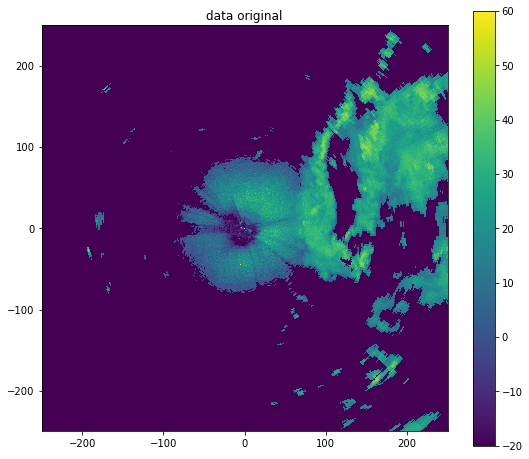

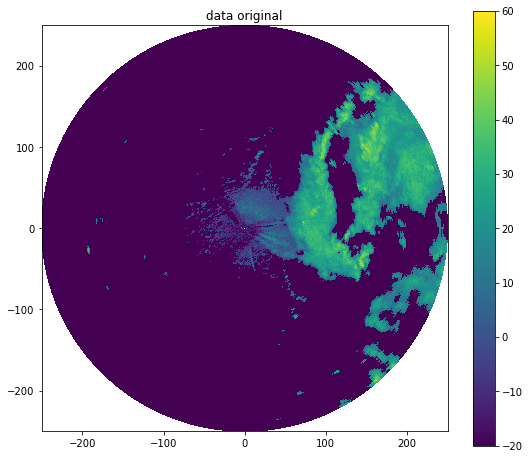

In [18]:

#Get azimuthal data
azi0 = rbdict['volume']['scan']['slice'][0]['slicedata']['rayinfo'][0]['data']
azidepth0 =  float(rbdict['volume']['scan']['slice'][0]['slicedata']['rayinfo'][0]['@depth'])
azirange0 = float(rbdict['volume']['scan']['slice'][0]['slicedata']['rayinfo'][0]['@rays'])
#azirange = 360.0 #wrong parameter for 2hn and 3rd override
azi0 =  azi0 * azirange0 / 2 ** azidepth0

#Get reflectivity data
elev_angle0 = str(rbdict['volume']['scan']['slice'][0]['posangle'])
data0 = rbdict['volume']['scan']['slice'][0]['slicedata']['rawdata']['data']
datadepth0 = float(rbdict['volume']['scan']['slice'][0]['slicedata']['rawdata']['@depth'])
datamin0 = float(rbdict['volume']['scan']['slice'][0]['slicedata']['rawdata']['@min'])
datamax0 = float(rbdict['volume']['scan']['slice'][0]['slicedata']['rawdata']['@max'])
data0 = datamin0 + data0 * (datamax0 - datamin0) / 2 ** datadepth0
#data_V0 = rbdict_V['volume']['scan']['slice'][0]['slicedata']['rawdata']['data']
#data_V0 = datamin0 + data_V0 * (datamax0 - datamin0) / 2 ** datadepth0



# Create range array
stoprange0 = float(rbdict['volume']['scan']['slice'][0]['stoprange'])
oDate0 = datetime.datetime.strptime(date, '%Y-%m-%d')
rangestep0 = float(rbdict['volume']['scan']['slice'][0]['rangestep'])
bins0 = float(rbdict['volume']['scan']['slice'][0]['slicedata']['rawdata']['@bins'])
r0 = np.arange(rangestep0, (bins0*rangestep0+rangestep0), rangestep0)


fig = pl.figure(figsize=(20, 10))
ax = fig.add_subplot(121)
ax.set_xlim(-250,250)
ax.set_ylim(-250,250)
ax, pm = wrl.vis.plot_ppi(data0, r=r0, az=azi0, ax=ax)
pm.set_clim(-20, 60)
cb = pl.colorbar(pm, shrink=0.8)
ax.set_title('data original')
'''ax = fig.add_subplot(122)
ax, pm = wrl.vis.plot_ppi(data_V0, r=r0, az=azi0, ax=ax)
ax.set_xlim(-250,250)
ax.set_ylim(-250,250)
pm.set_clim(-20, 20)
cb = pl.colorbar(pm, shrink=0.8)
ax.set_title('data filtered')'''

################################################################
#Get azimuthal data
azi1 = rbdict['volume']['scan']['slice'][1]['slicedata']['rayinfo'][0]['data']
azidepth1 =  float(rbdict['volume']['scan']['slice'][1]['slicedata']['rayinfo'][0]['@depth'])
azirange1 = float(rbdict['volume']['scan']['slice'][1]['slicedata']['rayinfo'][0]['@rays'])
#azirange = 360.0 #wrong parameter for 2hn and 3rd override
azi1 =  azi1 * azirange1 / 2 ** azidepth1

azi1_test=azi1*360/azirange1

#Get reflectivity data
elev_angle1 = str(rbdict['volume']['scan']['slice'][1]['posangle'])
data1 = rbdict['volume']['scan']['slice'][1]['slicedata']['rawdata']['data']
datadepth1 = float(rbdict['volume']['scan']['slice'][1]['slicedata']['rawdata']['@depth'])
datamin1 = float(rbdict['volume']['scan']['slice'][1]['slicedata']['rawdata']['@min'])
datamax1 = float(rbdict['volume']['scan']['slice'][1]['slicedata']['rawdata']['@max'])
data1 = datamin1 + data1 * (datamax1 - datamin1) / 2 ** datadepth1
#data_V1 = rbdict_V['volume']['scan']['slice'][1]['slicedata']['rawdata']['data']
#data_V1 = datamin1 + data_V1 * (datamax1 - datamin1) / 2 ** datadepth1



# Create range array
stoprange1 = float(rbdict['volume']['scan']['slice'][1]['stoprange'])
oDate1 = datetime.datetime.strptime(date, '%Y-%m-%d')
rangestep1 = float(rbdict['volume']['scan']['slice'][1]['rangestep'])
bins1 = float(rbdict['volume']['scan']['slice'][1]['slicedata']['rawdata']['@bins'])
r1 = np.arange(rangestep1, (bins1*rangestep1+rangestep1), rangestep1)


fig = pl.figure(figsize=(20, 10))
ax = fig.add_subplot(121)
#ax.set_xlim(-400,400)
#ax.set_ylim(-400,400)
ax, pm = wrl.vis.plot_ppi(data1, r=r1, az=azi1_test, ax=ax)
pm.set_clim(-20, 60)
cb = pl.colorbar(pm, shrink=0.8)
ax.set_title('data original')
'''ax = fig.add_subplot(122)
#ax.set_xlim(-400,400)
#ax.set_ylim(-400,400)
ax, pm = wrl.vis.plot_ppi(data_V1, r=r1, az=azi1, ax=ax)
pm.set_clim(-20, 20)
cb = pl.colorbar(pm, shrink=0.8)
ax.set_title('data filtered')'''



